# **F1 RACE PREDICTION MODEL**
Data and AI play a huge role in F1, especially in deciding race strategies ahead of the race. In this notebook I will walk you through my project

## **Overview**

After extracting the data from [Ergast API](http://ergast.com/mrd/) and preprocessing the data, I will be training an initial basic model with 2 hidden layers, which we will then evaluated to further refine the data structures and find any abnormal outliers.

## **Table of contents**
- 1.0 environment
- 2.0 F1 dataset
    - 2.1 Inspect the data
    - 2.2 Feature Correlation
    - 2.3 Feature Importance
    - 2.4 finishing the dataset
- 3.0 Preprocessing the data
    - 3.1 A classification problem
    - 3.2 Generate and split the final dataset
    - 3.3 Feature scaling
- 4.0 Initial prediction model
    - 4.1 Train and save the model
    - 4.2 Evaluate the model
- 5.0 Hyperparameter tuning via random search
- 6.0 Final prediction model
    - 6.1 Train and save the model
    - 6.2 Evaluate the model
- 7.0 Extensions and improvements

## **1.0 Project environment**
Import the necessary packages:

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.constraints import max_norm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## **2.0 F1 dataset**
The first step of building the F1 model was to extract the data which we get the raw data from [Ergast API](http://ergast.com/mrd/) then it was preprocessed and filtered to generate a the dataset we're using in this project.

### **2.1 Inspect the data**

In [11]:
data = pd.read_csv('dataset.csv')
data.head()

,race_id,driver_id,start_pos,gap_to_pole,cs_driver_results_missing,cs_driver_standing,cs_driver_podium_rate,csa_pos_change,csa_finish_pos,p3s_driver_results_missing,p3sa_pos_change_same_circuit,p3sa_finish_pos_same_circuit,cs_const_results_missing,cs_const_standing,cs_const_podium_rate,circuit_avg_pos_change,finish_pos
0,18,1,1,0.000,1,0,0.0,0.0,0.0,0,1.0,3.0,1,0,0.0,-1.24,1
1,18,2,5,0.075,1,0,0.0,0.0,0.0,0,1.5,4.0,1,0,0.0,0.67,2
2,18,3,7,0.198,1,0,0.0,0.0,0.0,0,5.0,7.0,1,0,0.0,-0.60,3
3,18,4,11,0.227,1,0,0.0,0.0,0.0,0,4.0,2.0,1,0,0.0,3.93,4
4,18,5,3,0.060,1,0,0.0,0.0,0.0,0,3.0,10.0,1,0,0.0,-0.95,5


### 2.2 Feature Correlation

<Axes: title={'center': 'Feature Correlations'}>

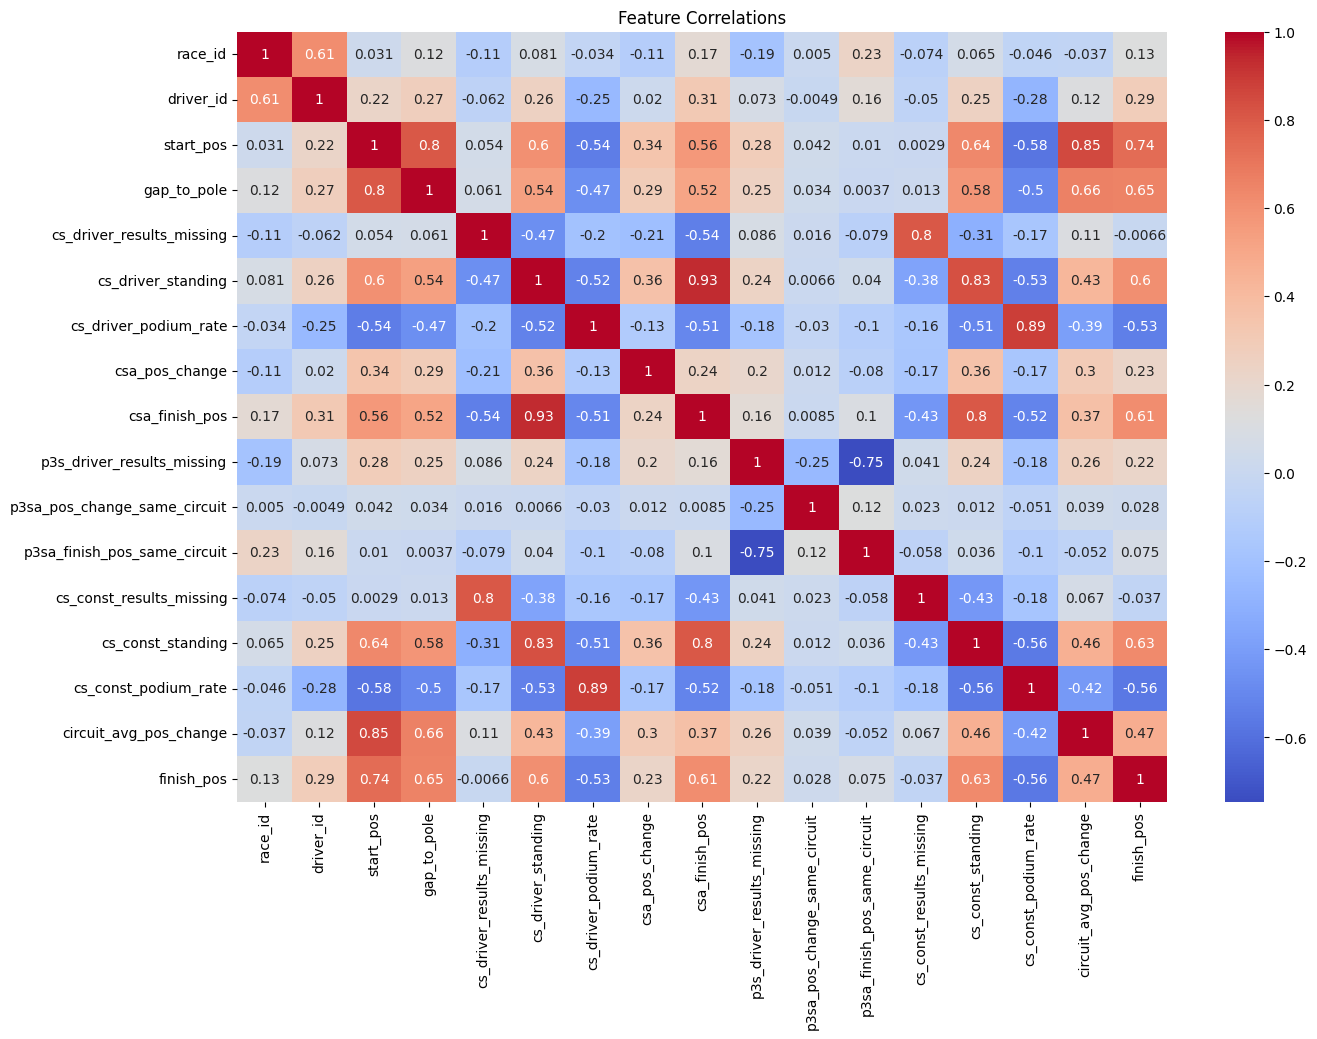

In [13]:
correlationTable = data.corr()
plt.figure(figsize=(15, 10))
plt.title("Feature Correlations")
sns.heatmap(correlationTable, annot=True, cmap='coolwarm')

### 2.3 Feature Importance
Feature importance give us a score for each data feature, the higher the score the more important the feature is.

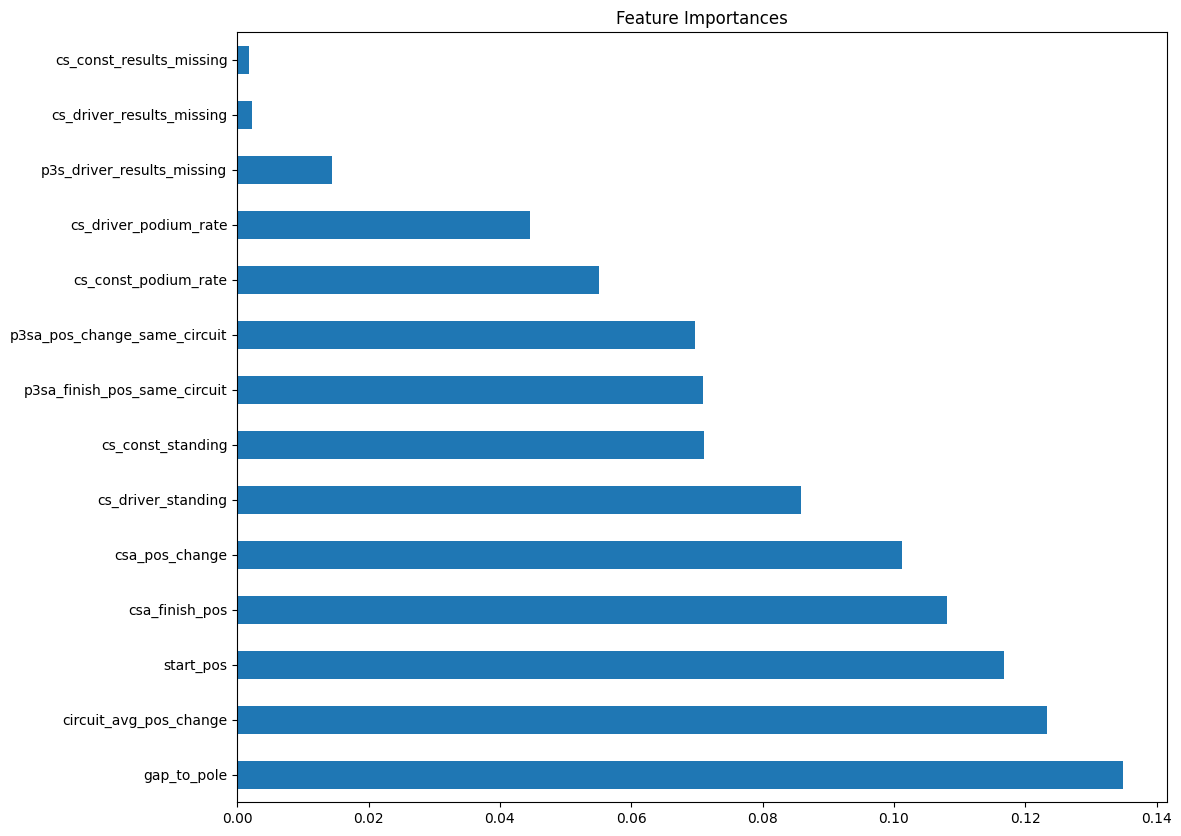

In [27]:
from sklearn.ensemble import ExtraTreesClassifier

# fit an Extra Trees model to the data
TreeModel = ExtraTreesClassifier()
X = data.iloc[:, 2:16]
y = data.iloc[:, -1]
TreeModel.fit(X,y)

# display the feature importances
model = pd.Series(TreeModel.feature_importances_, index=X.columns)

# plot the 16 most important features
model.nlargest(15).plot(kind='barh', figsize=(12, 10))
plt.title("Feature Importances")
plt.show()

The `gap_to_pole` and `circuit_avg_pos_change` is the most important feature in predicting the "finish_pos"

### 2.4 finishing the dataset
according to the test we just did the `race_id` and the `driver_id` have no use in our model and doesn't change the result of the race

In [ ]:
final_data = data.iloc[:, 2:]

let's get some data about our dataset

In [ ]:

info_check = final_data.describe()
info_check = info_check.transpose()
info_check

,count,mean,std,min,25%,50%,75%,max
start_pos,6008.0,10.654461,6.268620,0.0,5.00000,10.000,16.00000,26.0
gap_to_pole,6008.0,0.343519,0.279347,0.0,0.12075,0.274,0.50225,1.0
cs_driver_results_missing,6008.0,0.103362,0.304457,0.0,0.00000,0.000,0.00000,1.0
cs_driver_standing,6008.0,9.633489,6.993885,0.0,3.00000,9.000,15.00000,31.0
cs_driver_podium_rate,6008.0,0.170699,0.292606,0.0,0.00000,0.000,0.25000,1.0
csa_pos_change,6008.0,1.612109,2.557920,-11.0,0.00000,1.200,3.00000,17.0
csa_finish_pos,6008.0,7.841275,4.947897,0.0,3.90000,8.000,11.36000,23.0
p3s_driver_results_missing,6008.0,0.385652,0.486790,0.0,0.00000,0.000,1.00000,1.0
p3sa_pos_change_same_circuit,6008.0,0.896045,2.822021,-15.0,0.00000,0.000,2.00000,18.0
p3sa_finish_pos_same_circuit,6008.0,4.796247,5.095313,0.0,0.00000,3.500,8.50000,24.0


We can see that we have around 6008 rows with no issues here. but the mean and the STD is vary from variable to another, therefore we have to scale the data to prevent any bias

Let's check the relationship with the `finish_pos` and the features by plotting it

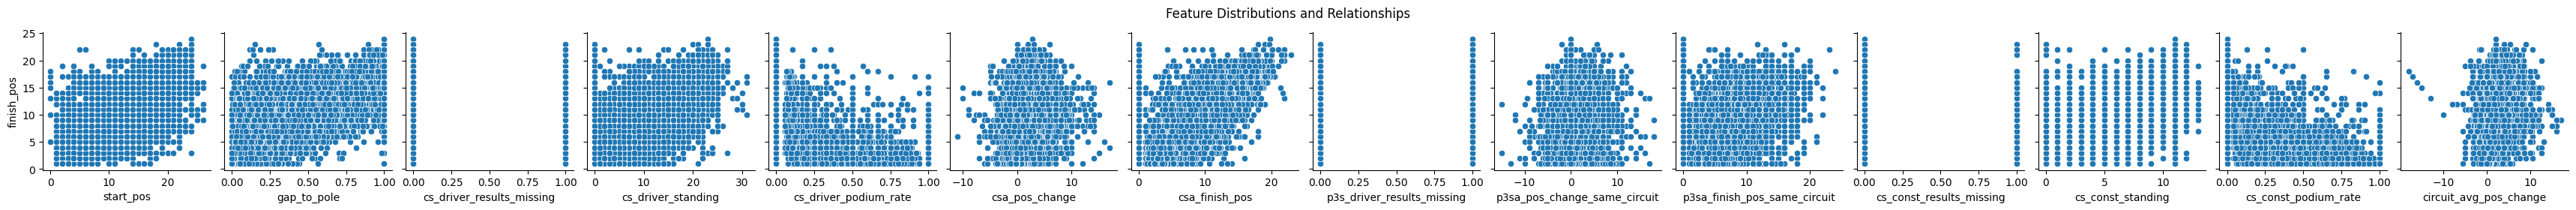

In [33]:
sns.pairplot(data=final_data,
             y_vars=['finish_pos'],
             x_vars=final_data.iloc[:, :-1].columns.values.tolist())
plt.suptitle('Feature Distributions and Relationships', y=1.08)
plt.show()